In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn.functional as F

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../survey_ops/utils')
sys.path.append('../survey_ops/')
import ephemerides
import geometry
import units
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN

In [3]:
from pytorch_utils import seed_everything

# Load Data

In [4]:
import json
with open("../data/2013-09-15_gband_fields.json") as f:
    old_id2pos = json.load(f)

In [5]:
id2pos = {}
for key in old_id2pos.keys():
    id2pos[int(key)] = old_id2pos[key]

In [6]:
import pandas as pd
schedule = pd.read_csv('../data/2013-09-15_gband_schedule.csv', dtype={'next_field':'Int64'})

In [7]:
field_id = 10
timestamp = schedule.iloc[field_id].time
field_ra, field_dec = id2pos[field_id]
field_az, field_el = ephemerides.equatorial_to_topographic(field_ra, field_dec, time=timestamp)
sun_ra, sun_dec = ephemerides.get_source_ra_dec("sun", time=timestamp)
sun_az, sun_el = ephemerides.equatorial_to_topographic(sun_ra, sun_dec, time=timestamp)
moon_ra, moon_dec = ephemerides.get_source_ra_dec("moon", time=timestamp)
moon_az, moon_el = ephemerides.equatorial_to_topographic(moon_ra, moon_dec, time=timestamp)

# Visualize schedule

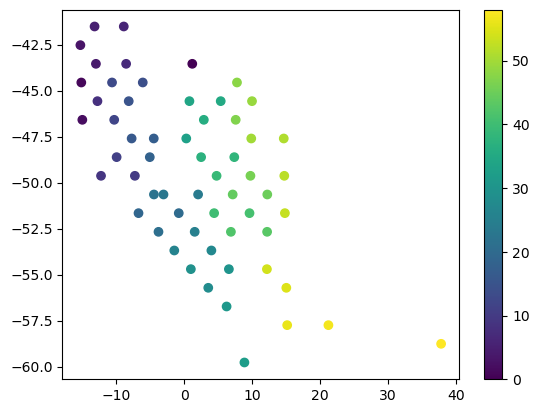

In [8]:

radec = np.array([id2pos[field_id] for field_id in schedule.field_id.values])
ra_shifted = np.where(radec[:, 0] > 180, radec[:, 0] - 360, radec[:, 0])
c = plt.scatter(ra_shifted, radec[:, 1], c = np.arange(len(ra_shifted)))
plt.colorbar(c)

In [12]:
schedule.field_id

0     44
1     23
2     53
3     11
4     16
5     20
6     54
7     57
8     33
9     19
10     9
11    46
12    31
13    36
14    30
15    42
16     3
17    21
18    49
19     4
20    29
21    10
22    39
23    22
24    58
25    24
26     0
27    48
28    25
29    51
30    18
31    28
32    38
33    26
34    12
35    35
36    41
37    32
38    52
39    13
40    45
41    56
42     2
43    27
44    37
45     5
46    34
47    50
48    43
49     6
50    55
51     8
52    14
53    15
54    17
55    47
56     1
57     7
58    40
Name: field_id, dtype: int64

In [11]:
dataset = TelescopeDatasetv0(schedule.iloc[:5], id2pos)

IndexError: index 44 is out of bounds for axis 0 with size 5

In [13]:
SEED = 10
env_name = 'TelescopeEnv-v0'
train_size = 1

seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [99]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset._obs_dim,
    'action_dim': dataset._action_dim,
    'hidden_dim': 256,
    'gamma': .99,
    'tau': .001,
    'device': device,
    'lr': 1e-5,
    'loss_fxn': F.huber_loss,
    'use_double': False
}

fit_config = {
    'num_epochs':50000,
    'batch_size': 32
    }

alg = DDQN(**alg_config)

agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

config_prefix = f"-n_unique={dataset._nfields}"
config_prefix += f"-use_double={alg_config['use_double']}"
config_prefix += f"-num_epochs={fit_config['num_epochs']}"
config_prefix += f"-batch_size={fit_config['batch_size']}"
config_prefix += f"-lr={alg_config['lr']}"
agent = Agent(**agent_config)

outdir = f'../results/{env_name}-{config_prefix}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [01:21<00:00, 615.16it/s]


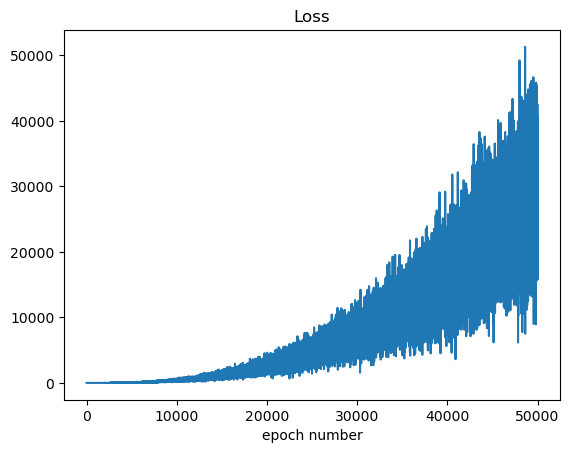

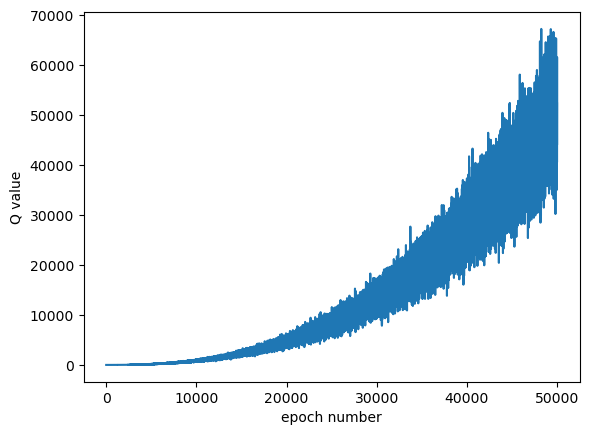

In [100]:
"""Train"""
agent.fit(
    dataset,
    outdir=outdir,
    **fit_config
    )
plt.plot(agent.loss_history)
plt.title('Loss')
plt.xlabel('epoch number')
plt.savefig(fig_outdir + 'train_loss_history.png')
plt.show();
plt.plot(agent.q_history)
plt.xlabel('epoch number')
plt.ylabel('Q value')
plt.savefig(fig_outdir + 'train_q_history.png')

In [101]:
# for eval step only
env_config = {
    # 'use_separation_reward': True,
    'use_field_id_reward': True
}

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset, **env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


/home/rachel/miniconda3/envs/cosmo_ml/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment gymnasium_env/TelescopeEnv-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/rachel/miniconda3/envs/cosmo_ml/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


In [102]:
"""Evaluate"""
eval_metrics = agent.evaluate(env=env, num_episodes=10)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 87.99it/s]

terminated at step 58
[-1.0, array(52., dtype=float32), array(56., dtype=float32), array(42., dtype=float32), array(38., dtype=float32), array(20., dtype=float32), array(14., dtype=float32), array(47., dtype=float32), array(53., dtype=float32), array(57., dtype=float32), array(36., dtype=float32), array(27., dtype=float32), array(41., dtype=float32), array(50., dtype=float32), array(49., dtype=float32), array(35., dtype=float32), array(21., dtype=float32), array(51., dtype=float32), array(55., dtype=float32), array(28., dtype=float32), array(58., dtype=float32), array(16., dtype=float32), array(48., dtype=float32), array(37., dtype=float32), array(39., dtype=float32), array(17., dtype=float32), array(29., dtype=float32), array(40., dtype=float32), array(46., dtype=float32), array(45., dtype=float32), array(7., dtype=float32), array(34., dtype=float32), array(15., dtype=float32), array(54., dtype=float32), array(43., dtype=float32), array(30., dtype=float32), array(32., dtype=float32), 

In [103]:
target_sequence

array([44, 23, 53, 11, 16, 20, 54, 57, 33, 19,  9, 46, 31, 36, 30, 42,  3,
       21, 49,  4, 29, 10, 39, 22, 58, 24,  0, 48, 25, 51, 18, 28, 38, 26,
       12, 35, 41, 32, 52, 13, 45, 56,  2, 27, 37,  5, 34, 50, 43,  6, 55,
        8, 14, 15, 17, 47,  1,  7, 40])

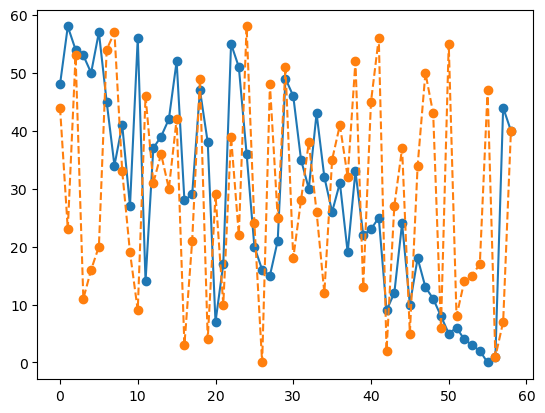

In [104]:
plt.plot(np.arange(len(eval_sequence[1:])), eval_sequence[1:], marker='o')
plt.plot(np.arange(len(target_sequence)), target_sequence, marker='o', linestyle='dashed')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 82.86it/s]

terminated at step 58
[-1.0, array(48., dtype=float32), array(58., dtype=float32), array(54., dtype=float32), array(53., dtype=float32), array(50., dtype=float32), array(57., dtype=float32), array(45., dtype=float32), array(34., dtype=float32), array(41., dtype=float32), array(27., dtype=float32), array(56., dtype=float32), array(14., dtype=float32), array(37., dtype=float32), array(39., dtype=float32), array(42., dtype=float32), array(52., dtype=float32), array(28., dtype=float32), array(29., dtype=float32), array(47., dtype=float32), array(38., dtype=float32), array(7., dtype=float32), array(17., dtype=float32), array(55., dtype=float32), array(51., dtype=float32), array(36., dtype=float32), array(20., dtype=float32), array(16., dtype=float32), array(15., dtype=float32), array(21., dtype=float32), array(49., dtype=float32), array(46., dtype=float32), array(35., dtype=float32), array(30., dtype=float32), array(43., dtype=float32), array(32., dtype=float32), array(26., dtype=float32), 

IndexError: invalid index to scalar variable.

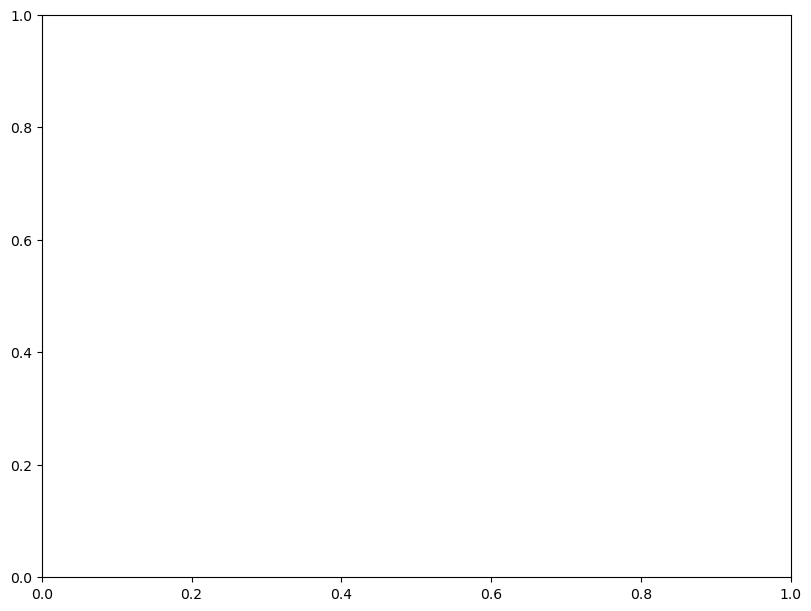

In [ ]:
j = 0

target_sequence = np.append(dataset.obs[0], dataset.next_obs[0, -1])
eval_sequence = eval_metrics['observations']['ep-0']

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(target_sequence[j][:, 1], target_sequence[j][:, 2], linestyle='dotted', label='target sequence', zorder=1, color='grey')
ax.plot(eval_sequence[:, 1], eval_sequence[:, 2], linestyle='dashed', label='target sequence', zorder=1, color='green')

for i, index in enumerate(target_sequence[j][:, 0]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
        color='black'
    elif i == len(target_sequence[j][:, 0])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 50
        label=None
    ax.scatter(target_sequence[j][i][1], target_sequence[j][i][2], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()
ax.set_xlabel('x coord')
ax.set_ylabel('y coord')
fig.savefig(fig_outdir + '2d_coords_true_and_pred.png')
plt.show();
plt.plot(eval_sequence[:, 0], marker='o')
plt.plot(target_sequence[0, :, 0], marker='o', label=True, color='grey', linestyle='dotted')
plt.xlabel('sequence number')
plt.ylabel('Field ID')
plt.savefig(fig_outdir + 'field_id_true_and_pred.png')

In [75]:
dataset.next_obs[0][-1]

40

In [ ]:
target_sequence = np.concatenate((dataset.obs[0][:, np.newaxis], dataset.next_obs[0]), axis=1)

In [85]:
np.append(dataset.obs[0], dataset.next_obs[0, -1])

array([44, 23, 53, 11, 16, 20, 54, 57, 33, 19,  9, 46, 31, 36, 30, 42,  3,
       21, 49,  4, 29, 10, 39, 22, 58, 24,  0, 48, 25, 51, 18, 28, 38, 26,
       12, 35, 41, 32, 52, 13, 45, 56,  2, 27, 37,  5, 34, 50, 43,  6, 55,
        8, 14, 15, 17, 47,  1,  7, 40])

In [82]:
np.stack((dataset.obs[0], dataset.next_obs[0,-1][:, np.newaxis]))

IndexError: invalid index to scalar variable.

In [ ]:
dataset.obs[0], dataset.next_obs[0][:, -1][np.newaxis, :, :]

In [ ]:
# for eval step only
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v2,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset, **env_config)